<a href="https://colab.research.google.com/github/as791/Adversarial-Example-Attack-and-Defense/blob/master/Adversarial_Example_(Attack_and_defense).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 391 Validation data: 79 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [6]:


print(device)

cuda


## Defense

In [7]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    
    self.fc1 = nn.Linear(3136, 200)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(200, 200)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    #print(x.shape)
    #x = torch.flatten(x, 1)
    x = x.view(-1, 7*7*64) # Flattens to 1x8*8*128 row vector
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout1(x)
    x = self.fc3(x)
    #x = F.softmax(x, dim=1)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    
    self.fc1 = nn.Linear(3136, 200)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(200, 200)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    #print(x.shape)
    #x = torch.flatten(x, 1)
    x = x.view(-1, 7*7*64) # Flattens to 1x8*8*128 row vector
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout1(x)
    x = self.fc3(x)
    #x = F.softmax(x, dim=1)
    return x

In [8]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [9]:
def fit_and_saveF(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs,retrain):
    file_path = "./model/Exp2_F_MNIST.pth"
    if(retrain == True or not(os.path.exists(file_path))):
        loss,val_loss=fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs)
        torch.save(model.state_dict(), file_path)
        np.save('./model/Exp2_F_MNIST_loss_array.npy', loss)
        np.save('./model/Exp2_F_MNIST_val_loss_array.npy', val_loss)
    else:
        model.load_state_dict(torch.load(file_path))
        loss = np.load('./model/Exp2_F_MNIST_loss_array.npy')
        val_loss = np.load('./model/Exp2_F_MNIST_val_loss_array.npy')
    return loss,val_loss

In [10]:
def fit_and_saveF1(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs,retrain):
    file_path = "./model/Exp2_F1_MNIST.pth"
    if(retrain == True or not(os.path.exists(file_path))):
        loss,val_loss=fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs)
        torch.save(model.state_dict(), file_path)
        np.save('./model/Exp2_F1_MNIST_loss_array.npy', loss)
        np.save('./model/Exp2_F1_MNIST_val_loss_array.npy', val_loss)
    else:
        model.load_state_dict(torch.load(file_path))
        loss = np.load('./model/Exp2_F1_MNIST_loss_array.npy')
        val_loss = np.load('./model/Exp2_F1_MNIST_val_loss_array.npy')
    return loss,val_loss

In [11]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit_and_saveF(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs,False)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit_and_saveF1(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs,False)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  return model

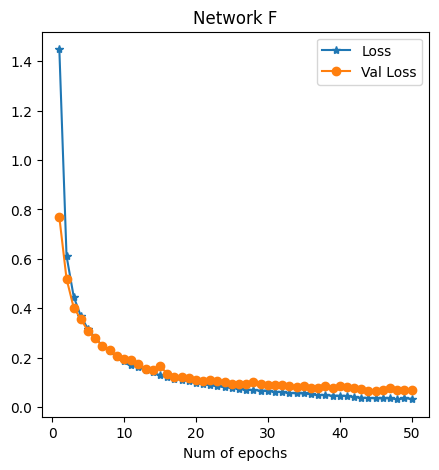

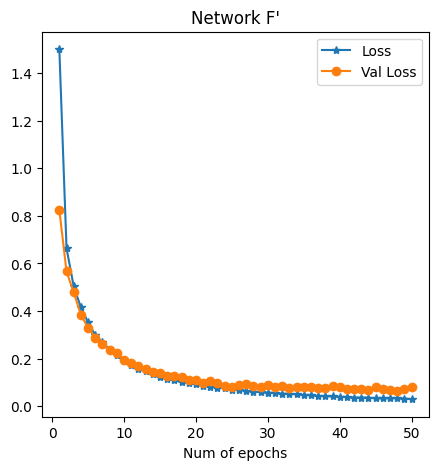

In [12]:
Temp=100
epochs=50
modelF1 = defense(device,train_loader,val_loader,test_loader,epochs,Temp)

In [13]:
def test_model(model,device,test_loader):
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() == target.item():
            correct += 1
            
    final_acc = correct/float(len(test_loader))
    print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))
    
test_model(modelF1, device,test_loader)

Test Accuracy = 9851 / 10000 = 0.9851


In [14]:
from torch.utils.data import Dataset

class AugmentedDataset(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = X
        self.y = y
 
    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)
 
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [15]:
def test_from_custom(model,device,epsilon,attack):
  correct = 0
  adv_examples = []
  epsilon_string = str(epsilon).split('.')
  path_to_load = ['./custom_datasets/MNIST_', attack, '_',epsilon_string[1], '_test.pth']
  path = "".join(path_to_load)
  print(path)
  test_load = torch.load(path)
  test_loader = torch.utils.data.DataLoader(test_load,batch_size=1,shuffle=True)
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = data.squeeze().detach().cpu().numpy()
              adv_examples.append( (target.item(), init_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = data.squeeze().detach().cpu().numpy()
              adv_examples.append( (target.item(), init_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

./custom_datasets/MNIST_fgsm_007_test.pth
Epsilon: 0.007	Test Accuracy = 9838 / 10000 = 0.9838
./custom_datasets/MNIST_fgsm_01_test.pth
Epsilon: 0.01	Test Accuracy = 9816 / 10000 = 0.9816
./custom_datasets/MNIST_fgsm_02_test.pth
Epsilon: 0.02	Test Accuracy = 9825 / 10000 = 0.9825
./custom_datasets/MNIST_fgsm_03_test.pth
Epsilon: 0.03	Test Accuracy = 9771 / 10000 = 0.9771
./custom_datasets/MNIST_fgsm_05_test.pth
Epsilon: 0.05	Test Accuracy = 9730 / 10000 = 0.973
./custom_datasets/MNIST_fgsm_1_test.pth
Epsilon: 0.1	Test Accuracy = 9556 / 10000 = 0.9556
./custom_datasets/MNIST_fgsm_2_test.pth
Epsilon: 0.2	Test Accuracy = 8677 / 10000 = 0.8677
./custom_datasets/MNIST_fgsm_3_test.pth
Epsilon: 0.3	Test Accuracy = 7049 / 10000 = 0.7049


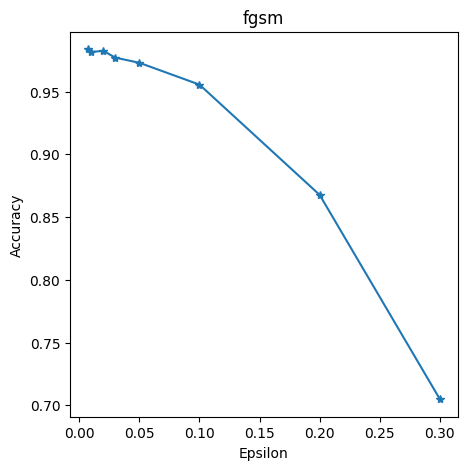

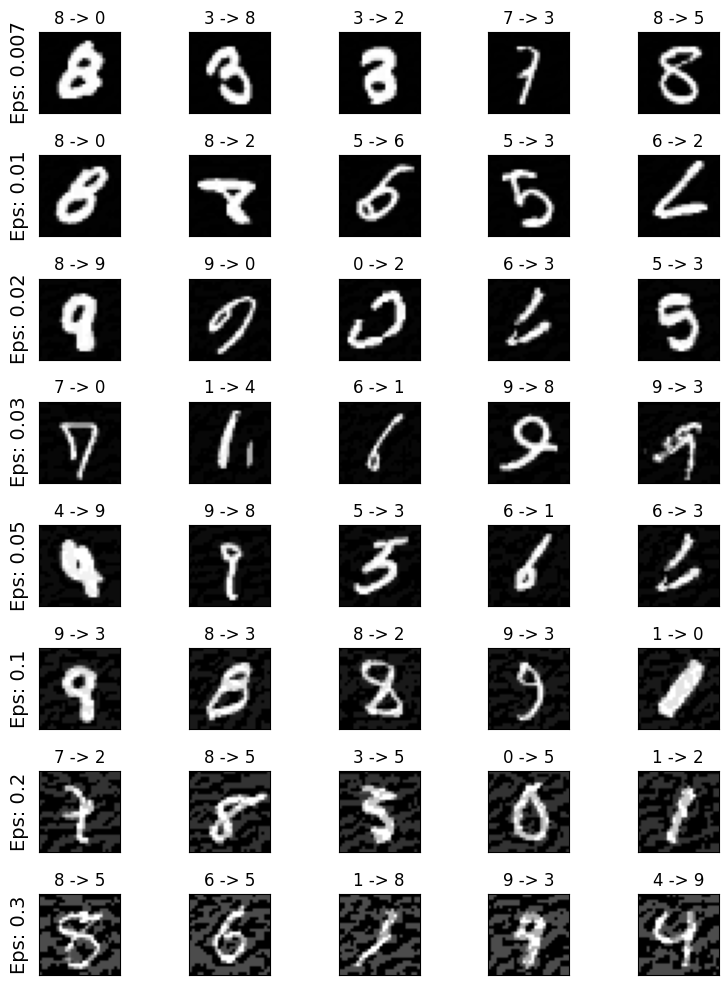

./custom_datasets/MNIST_mifgsm_007_test.pth
Epsilon: 0.007	Test Accuracy = 9835 / 10000 = 0.9835
./custom_datasets/MNIST_mifgsm_01_test.pth
Epsilon: 0.01	Test Accuracy = 9848 / 10000 = 0.9848
./custom_datasets/MNIST_mifgsm_02_test.pth
Epsilon: 0.02	Test Accuracy = 9812 / 10000 = 0.9812
./custom_datasets/MNIST_mifgsm_03_test.pth
Epsilon: 0.03	Test Accuracy = 9799 / 10000 = 0.9799
./custom_datasets/MNIST_mifgsm_05_test.pth
Epsilon: 0.05	Test Accuracy = 9759 / 10000 = 0.9759
./custom_datasets/MNIST_mifgsm_1_test.pth
Epsilon: 0.1	Test Accuracy = 9605 / 10000 = 0.9605
./custom_datasets/MNIST_mifgsm_2_test.pth
Epsilon: 0.2	Test Accuracy = 8916 / 10000 = 0.8916
./custom_datasets/MNIST_mifgsm_3_test.pth
Epsilon: 0.3	Test Accuracy = 7570 / 10000 = 0.757


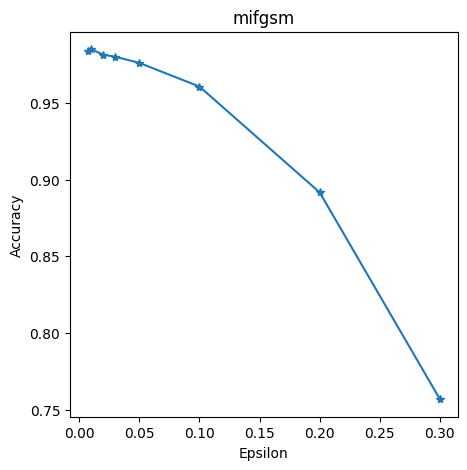

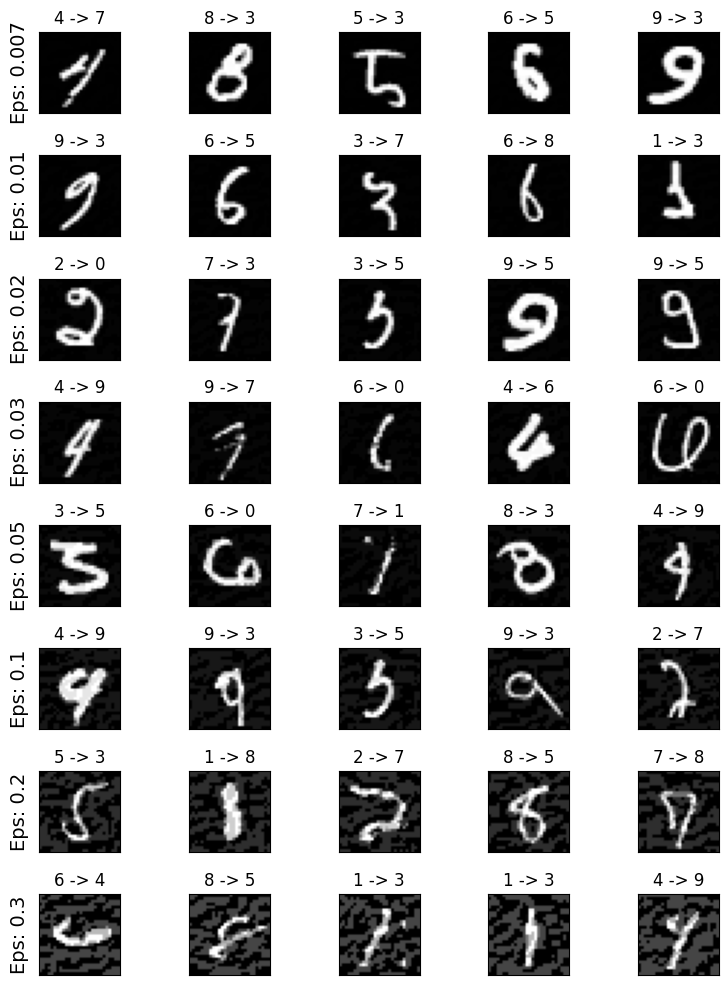

In [16]:
epsilons = [0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]

for attack in ("fgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test_from_custom(modelF1, device,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

In [17]:
def test_from_custom_deepfool(model,device):
  correct = 0
  adv_examples = []
  path_to_load = ['./custom_datasets/MNIST_deepfool_test.pth']
  path = "".join(path_to_load)
  print(path)
  test_load = torch.load(path)
  test_loader = torch.utils.data.DataLoader(test_load,batch_size=1,shuffle=True)
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() == target.item():
          correct += 1
      else:
          if len(adv_examples) < 5:
              adv_ex = data.squeeze().detach().cpu().numpy()
              adv_examples.append( (target.item(), init_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

  return final_acc, adv_examples

./custom_datasets/MNIST_deepfool_test.pth
Test Accuracy = 9120 / 10000 = 0.912
./custom_datasets/MNIST_deepfool_test.pth
Test Accuracy = 9141 / 10000 = 0.9141
./custom_datasets/MNIST_deepfool_test.pth
Test Accuracy = 9134 / 10000 = 0.9134
./custom_datasets/MNIST_deepfool_test.pth
Test Accuracy = 9120 / 10000 = 0.912
./custom_datasets/MNIST_deepfool_test.pth
Test Accuracy = 9133 / 10000 = 0.9133


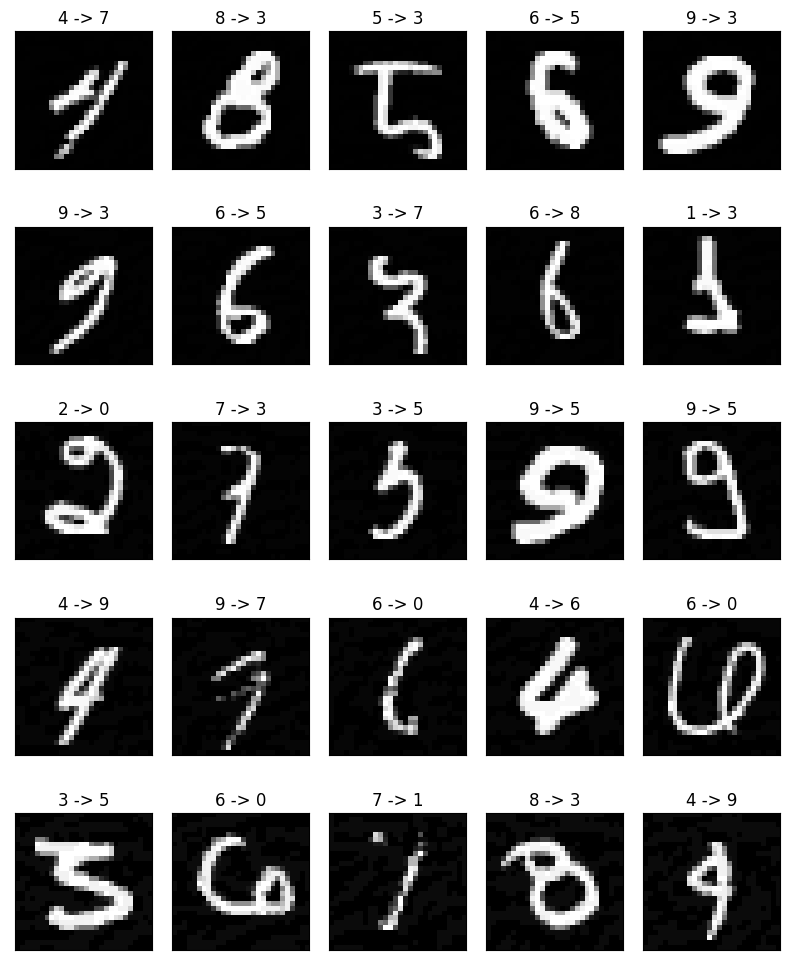

In [18]:
for i in range(5):
    acc, ex = test_from_custom_deepfool(modelF1, device)
    accuracies.append(acc)
    examples.append(ex)

cnt = 0
plt.figure(figsize=(8,10))
for i in range(5):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(5,len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [19]:
def test_from_custom_spatial(model,device,target):
  correct = 0
  adv_examples = []
  path_to_load = ['./custom_datasets/MNIST_spatial_', target, '_test.pth']
  path = "".join(path_to_load)
  print(path)
  test_load = torch.load(path)
  test_loader = torch.utils.data.DataLoader(test_load,batch_size=1,shuffle=True)
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() == target.item():
          correct += 1
      else:
          if len(adv_examples) < 5:
              adv_ex = data.squeeze().detach().cpu().numpy()
              adv_examples.append( (target.item(), init_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Target label: {}\tTest Accuracy = {} / {} = {}".format(target, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

./custom_datasets/MNIST_spatial_0_test.pth
Target label: tensor([9], device='cuda:0')	Test Accuracy = 9527 / 10000 = 0.9527
./custom_datasets/MNIST_spatial_1_test.pth
Target label: tensor([4], device='cuda:0')	Test Accuracy = 9577 / 10000 = 0.9577
./custom_datasets/MNIST_spatial_2_test.pth
Target label: tensor([8], device='cuda:0')	Test Accuracy = 9554 / 10000 = 0.9554
./custom_datasets/MNIST_spatial_3_test.pth
Target label: tensor([5], device='cuda:0')	Test Accuracy = 9486 / 10000 = 0.9486
./custom_datasets/MNIST_spatial_4_test.pth
Target label: tensor([1], device='cuda:0')	Test Accuracy = 9622 / 10000 = 0.9622


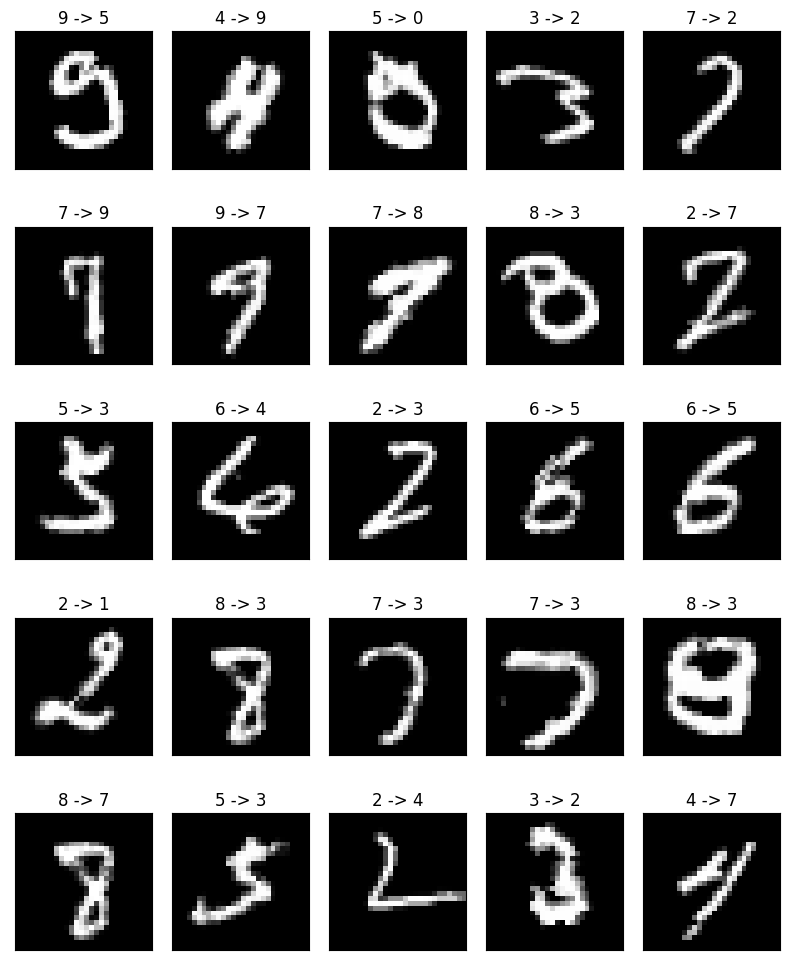

In [20]:
  targets = ['0', '1', '2', '3', '4']

  accuracies = []
  examples = []
  for target in targets:
      acc, ex = test_from_custom_spatial(modelF1, device,target)
      accuracies.append(acc)
      examples.append(ex)

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(targets)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(targets),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()